# Task 3

# Imports

In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})
## add any other additional packages that you need. You are free to use any packages for vizualization.

## Part 1:

Recall as a final goal of this project. We want to build and deploy ensemble machine learning models in the cloud, where features are outputs of different climate models and the target is the actual rainfall observation. In this milestone, you'll actually build these ensemble machine learning models in the cloud.  

**Your tasks:**

1. Read the data CSV from your s3 bucket. 
2. Drop rows with nans. 
3. Split the data into train (80%) and test (20%) portions with `random_state=123`. 
4. Carry out EDA of your choice on the train split. 
5. Train ensemble machine learning model using `RandomForestRegressor` and evaluate with metric of your choice (e.g., `RMSE`) by considering `Observed` as the target column. 
6. Discuss your results. Are you getting better results with ensemble models compared to the individual climate models? 

> Recall that individual columns in the data are predictions of different climate models. 

#### Step 1: Read the data CSV from s3 bucket

In [2]:
## Depending on the permissions that you provided to your bucket you might need to provide your aws credentials
## to read from the bucket, if so provide with your credentials and pass as storage_options=aws_credentials
# aws_credentials = {"key": "","secret": "","token":""}

In [3]:
# credentials
aws_credentials = {
    "key": "<key>",
    "secret": "<secret>",
    "token": "<token>"
}

In [4]:
# get data from s3 bucket
df = pd.read_csv(
    "s3://mds-s3-23/output/ml_data_SYD.csv", 
    index_col=0,
    parse_dates=True, 
    storage_options=aws_credentials
)

In [5]:
df.head()

,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM-1-2-HAM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,SAM0-UNICON,TaiESM1,Observed
time,,,,,,,,,,,,,,,,,,,,,
1889-01-01,0.040427,1.814552,35.579336,4.268112e+00,1.107466e-03,11.410537,3.322009e-08,2.668800,1.321215,1.515293,...,4.244226e-13,1.390174e-13,6.537884e-05,3.445495e-06,1.576096e+01,4.759651e-05,2.451075,0.221324,2.257933,0.006612
1889-01-02,0.073777,0.303965,4.596520,1.190141e+00,1.015323e-04,4.014984,1.312700e+00,0.946211,2.788724,4.771375,...,4.409552e+00,1.222283e-01,1.049131e-13,4.791993e-09,3.675510e-01,4.350863e-01,0.477231,3.757179,2.287381,0.090422
1889-01-03,0.232656,0.019976,5.927467,1.003845e-09,1.760345e-05,9.660565,9.103720e+00,0.431999,0.003672,4.233980,...,2.269300e-01,3.762301e-01,9.758706e-14,6.912302e-01,1.562869e-01,9.561101e+00,0.023083,0.253357,1.199909,1.401452
1889-01-04,0.911319,13.623777,8.029624,8.225225e-02,1.808932e-01,3.951528,1.317160e+01,0.368693,0.013578,15.252495,...,2.344586e-02,4.214019e-01,7.060915e-03,3.835721e-02,2.472226e-07,5.301038e-01,0.002699,2.185454,2.106737,14.869798
1889-01-05,0.698013,0.021048,2.132686,2.496841e+00,4.708019e-09,2.766362,1.822940e+01,0.339267,0.002468,11.920356,...,4.270161e-13,1.879692e-01,4.504985e+00,3.506923e-07,1.949792e-13,1.460928e-10,0.001026,2.766507,1.763335,0.467628


#### Step 2: Drop rows with nans

In [6]:
df = df.dropna()

#### Step 3: Split data

From Step 1, we can see that we are dealing with time series data; therefore when spliting data, we set `shuffle=False` so that we will not disrupt the temporal order and not leak the information to the test set. 

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123, shuffle=False)

#### Step 4: EDA

In [8]:
train_df.describe()

,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM-1-2-HAM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,SAM0-UNICON,TaiESM1,Observed
count,36791.000000,36791.000000,3.679100e+04,3.679100e+04,3.679100e+04,36791.000000,3.679100e+04,3.679100e+04,36791.000000,3.679100e+04,...,3.679100e+04,3.679100e+04,3.679100e+04,3.679100e+04,3.679100e+04,36791.000000,36791.000000,3.679100e+04,3.679100e+04,36791.000000
mean,2.418944,2.896285,3.664706e+00,2.211732e+00,2.767789e+00,3.101337,3.595210e+00,3.498250e+00,2.966061,2.597035e+00,...,3.212287e+00,1.322584e+00,2.079747e+00,1.491225e+00,1.722461e+00,2.445703,2.838375,3.319782e+00,3.441402e+00,2.777732
std,6.781286,6.879413,7.214366e+00,6.544580e+00,6.010654e+00,6.500920,7.387164e+00,7.078336e+00,7.024007,5.798388e+00,...,6.922027e+00,4.920043e+00,5.407070e+00,4.838441e+00,4.845465e+00,5.808536,6.980070,7.882558e+00,7.571911e+00,8.284286
min,0.000000,0.000000,9.161142e-14,4.370610e-24,1.107181e-24,0.000000,-4.503054e-17,-3.186177e-19,0.000000,-9.934637e-19,...,3.315622e-13,1.088608e-13,9.204019e-14,9.479186e-33,1.429162e-13,0.000000,0.000000,-3.604673e-17,-2.148475e-14,0.000000
25%,0.054225,0.021811,2.585608e-02,4.033173e-04,2.657978e-03,0.138223,8.795451e-02,9.175020e-02,0.023616,1.287460e-02,...,1.408160e-04,1.271249e-13,1.357380e-13,5.740648e-05,1.852582e-13,0.005352,0.009713,3.741288e-02,4.905343e-02,0.008818
50%,0.190864,0.491260,5.759248e-01,9.092876e-02,3.053905e-01,0.633034,8.247926e-01,8.422411e-01,0.368521,4.410744e-01,...,2.130571e-01,1.659617e-03,1.172821e-01,3.069196e-02,5.106960e-02,0.168483,0.248595,6.406431e-01,6.675421e-01,0.182341
75%,1.418816,2.388891,3.547054e+00,1.332665e+00,2.526573e+00,3.185832,3.742353e+00,3.615350e+00,2.682899,2.351880e+00,...,2.703393e+00,3.560368e-01,1.218444e+00,6.646839e-01,7.905046e-01,1.822219,2.428031,3.206986e+00,3.211678e+00,1.648488
max,149.967634,157.605713,8.946575e+01,1.344652e+02,8.713472e+01,109.098855,1.401478e+02,1.375916e+02,135.569753,1.342262e+02,...,9.306766e+01,1.038506e+02,8.005998e+01,1.051568e+02,8.045783e+01,114.898109,163.164524,1.549718e+02,1.166465e+02,256.455080


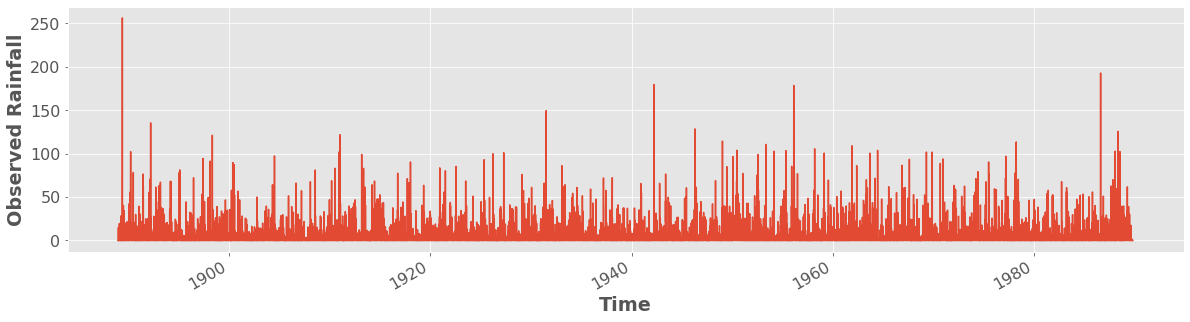

In [9]:
# Plot the data
train_df["Observed"].plot.line(xlabel="Time", ylabel="Observed Rainfall", legend=False, figsize=(20,5));

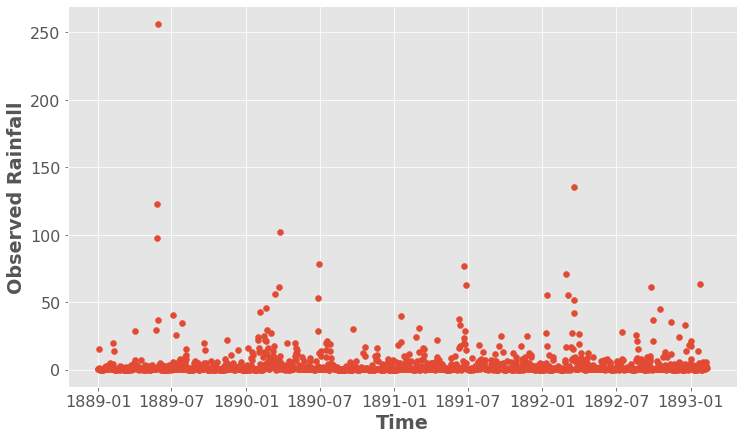

In [10]:
# Create a scatter plot of a portion of the data to see if there's a clearer pattern.

plt.figure(figsize=(12, 7))
plt.scatter(x=train_df.index[0:1500], y=train_df['Observed'][0:1500])
plt.xlabel('Time')
plt.ylabel('Observed Rainfall')
plt.show();

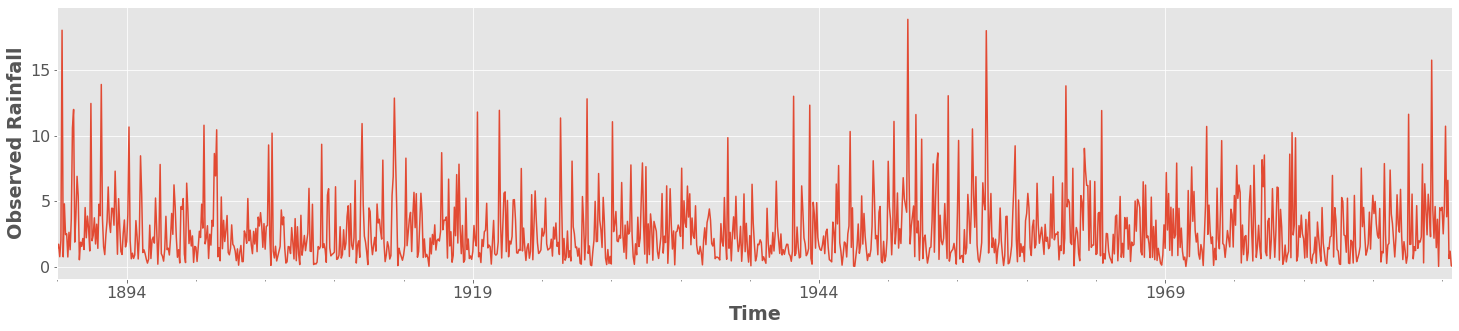

In [11]:
# resample the data into months to have better view of trend and seasonality
monthly_data = train_df[["Observed"]].resample("1M").mean()
monthly_data.index.fred="M"
monthly_data.plot(xlabel="Time", ylabel="Observed Rainfall", legend=False, figsize=(25,5));

In [12]:
# decompose the timeseries data into trend and seasonality
model = seasonal_decompose(monthly_data[["Observed"]], model="additive", period=12) 

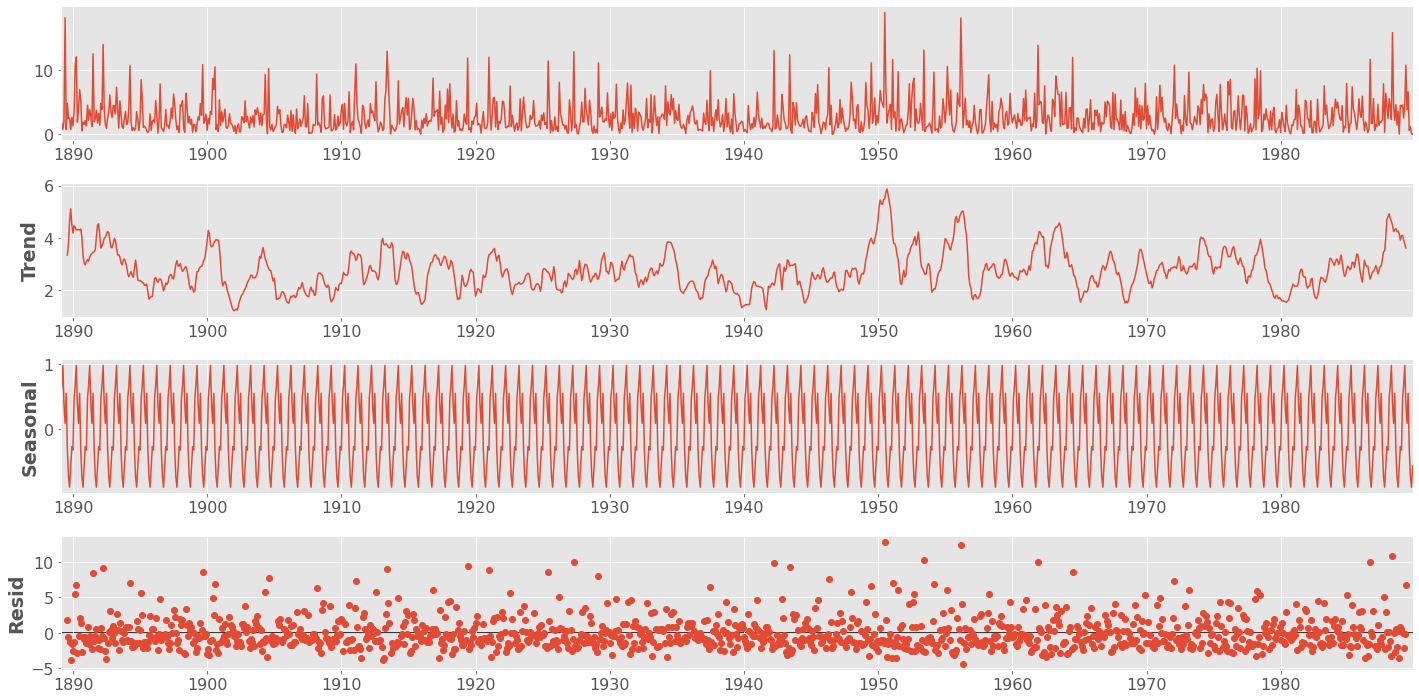

In [13]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(20, 10))
    model.plot(); plt.tight_layout()

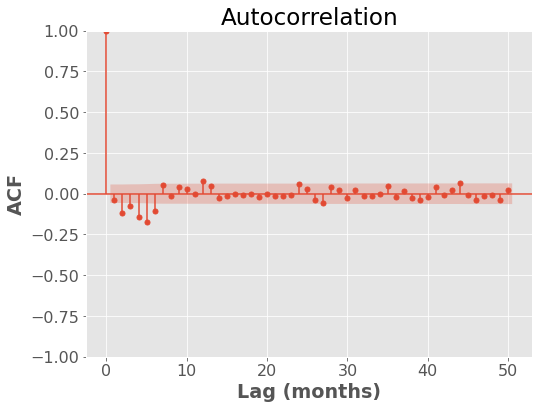

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(model.resid.dropna(), lags=50)
plt.ylabel("ACF")
plt.xlabel("Lag (months)");

**Observations:**
- The data has no obvious trend. 
- The timeseries has seasonal pattern of 12-month interval
- From the ACF plot, it seems that we extracted seasonal pattern nicely. However, there still seems to be some temporal dependence at low lags.

#### Step 5: Train ensemble ML model using `RandomForestRegressor` 

In [15]:
X_train, y_train = train_df.drop(columns="Observed"), train_df["Observed"]
X_test, y_test = test_df.drop(columns="Observed"), test_df["Observed"]

In [16]:
model = RandomForestRegressor(random_state=123)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

In [17]:
# Evaluate with RMSE metric
print(f"Train RMSE score: {mean_squared_error(y_train, model.predict(X_train), squared=False):.3f}")
print(f"Test RMSE score: {mean_squared_error(y_test, model.predict(X_test), squared=False):.3f}")

Train RMSE score: 3.242
Test RMSE score: 8.077


#### Step 6: Discuss the result

In [18]:
# Store the prediction of the ensemble model in a new column
test_df = test_df.copy()
test_df.loc[:, 'RandomForest'] = model.predict(X_test)
test_df.head()

,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,SAM0-UNICON,TaiESM1,Observed,RandomForest
time,,,,,,,,,,,,,,,,,,,,,
1989-10-20,0.219339,0.001521,1.117539e-13,4.180110e-01,4.989895,1.161463,0.135131,2.092660e+00,0.181639,-4.895401e-20,...,1.247387e-13,3.552636e+00,4.248013e-18,3.485942e-02,0.068946,0.125749,0.033357,1.895946,0.700673,1.083308
1989-10-21,0.055218,1.819894,1.566437e+00,1.269076e-08,0.915879,0.676991,0.008308,9.136886e-01,0.956078,-7.228011e-20,...,1.292251e-13,2.833620e-01,4.177801e-01,1.130954e-07,0.096040,0.078274,1.824664,0.973379,0.341154,1.034965
1989-10-22,0.013428,0.588268,1.072806e-13,2.165644e-02,7.124331,2.456995,3.445798,7.479689e-01,0.009526,1.115799e-02,...,2.089910e-01,1.022562e-13,2.155149e+00,1.850952e-08,8.172772,0.030886,2.806819,0.000277,0.009556,3.002688
1989-10-23,1.452529,0.561795,5.502284e-01,5.186514e+01,3.420923,4.374916,21.353840,1.860805e-13,0.081571,6.265640e-02,...,3.488716e-02,1.122544e-13,3.248625e+00,1.601959e-13,1.218779,1.615460,0.107130,0.035640,0.597030,6.262447
1989-10-24,0.148280,0.491199,3.590355e-01,2.572335e+00,5.143028,7.720900,4.057471,3.618783e-02,0.003499,2.167654e+00,...,1.223828e-13,1.107384e-13,4.513370e+00,2.978377e-02,1.944571,1.315995,0.504264,0.836204,2.249953,2.353131


In [19]:
# Create a data frame to store rmse of all models 
rmse_results = {}
# get the list of all model names
cols = test_df.columns.to_list() 
cols.remove("Observed")
# store rmse of the current model to the dictionary
for c in cols:
    rmse_results[c] = mean_squared_error(test_df["Observed"], test_df[c], squared=False)
rmse_results_df = pd.DataFrame(rmse_results.items())
rmse_results_df = rmse_results_df.set_axis(['Model Name', 'RMSE Score'], axis=1, inplace=False)
rmse_results_df.sort_values(by=['RMSE Score'],ignore_index=True)

,Model Name,RMSE Score
0,RandomForest,8.076678
1,FGOALS-g3,8.825898
2,KIOST-ESM,8.929471
3,MPI-ESM1-2-HR,9.136171
4,NESM3,9.238419
5,MPI-ESM1-2-LR,9.358796
6,GFDL-CM4,9.460040
7,MRI-ESM2-0,9.494019
8,EC-Earth3-Veg-LR,9.560820
9,NorESM2-LM,9.801393


**Observation:**  
We get a better RMSE score **8.07** for test data with ensemble model `RandomForestRegressor` when compared to the other individual climate models as shown above.

## Part 2:

### Preparation for deploying model next week

***NOTE: Complete task 4 from the milestone3 before coming here***

We’ve found the best hyperparameter settings with MLlib (from the task 4 from milestone3), here we then use the same hyperparameters to train a scikit-learn model.

Best hyperparameters:

- `n_estimators=100`
- `max_depth=5`
- `bootstrap=False`

Best CV RMSE score: **8.17**

In [20]:
model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

In [21]:
print(f"Train RMSE score: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}")
print(f"Test RMSE score: {mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")

Train RMSE score: 8.10
Test RMSE score: 7.81


**Observation:**  
It's clear that we get an even better test RMSE score **7.81** after hyperparameter tuning and using the best hyperparamters for the `RandomForestRegressor` model.

In [22]:
# ready to deploy
dump(model, "model.joblib")

['model.joblib']

***Upload model.joblib to s3 under output folder. You choose how you want to upload it (using CLI, SDK, or web console).***

![](../../images/milestone_3_task_3b.png)